### There is more confusion on whether grid should be used in machine learning or are we using averages from dataset to setup a model
### Untill that is clear, the ML works stops here

In [1]:
#read all the data and filter for only some
from ml_utils import *
import time

In [2]:
#get the required clusters 
client = get_cluster("UCSB0021", cores = 40)
client.cluster;

In [3]:
#modify the function if you want to pass the parameter
def read_all_simulation():
    '''prepare cluster list and read to create ensemble(group of data)
    use preprocess to select only certain dimension and a variable'''
    # Start timing
    start_time = time.time()

    # read all simulations as a list
    cluster_list = sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))
    cluster_list = cluster_list[1:len(cluster_list)]

    # only select latitude, longitude, time, and using this in preprocess steps
    def preprocess(ds):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected
        before the data is combined'''
        ds = fix_time(ds)
        ds = ds[['lat', 'lon', 'time', "LEAFCN"]]
        return ds
    
    # read the list and load it for the notebook
    ds = xr.open_mfdataset(cluster_list,
                              combine='nested',
                              preprocess=lambda ds: preprocess(ds),
                              parallel=True,
                              concat_dim="ens")

    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time taken to run read_all_simulation(): {:.2f} seconds".format(elapsed_time))
    return ds
   

In [4]:
ds = read_all_simulation()

Time taken to run read_all_simulation(): 22.15 seconds


**The weight_landarea_gridcells function available inside the utils is designed only for dataarray, 
I am changing to work with dataset.**

In [5]:
#read the landarea data
landarea = xr.open_dataset('/glade/campaign/cgd/tss/projects/PPE/helpers/sparsegrid_landarea.nc')['landarea']

def weight_landarea_gridcells(ds, landarea):
    for varname in ds.variables:
        # Skip coordinates and auxiliary variables
        if varname not in ds.coords:
            var = ds[varname]
            # Calculate the weighted mean of the variable over grid cells
            weighted_mean = var.weighted(landarea).mean(dim='gridcell')
            # Assign the weighted mean back to the dataset
            ds[varname] = weighted_mean
    return ds
   

**The dataset is weighted by gridcells at this point** 

In [6]:
ds = weight_landarea_gridcells(ds, landarea)

**Weight the dataset based on yearly average. Note: these functions are designed to workwith dataset and not with datarray and these functions are also different from what is available in utils. We have to change in the utils later**

In [7]:
def yearly_weighted_average(ds):
    for varname in ds.variables:
        # Skip coordinates and auxiliary variables
        if varname not in ds.coords:
            var = ds[varname]
            # Get the array of number of days from the main dataset
            days_in_month = ds['time.daysinmonth']

            # # Multiply each month's data by corresponding days in month
            weighted_month = (days_in_month * var).groupby("time.year").sum(dim='time')

            # # Total days in the year
            total_days = days_in_month.groupby("time.year").sum(dim='time')

            #  Calculate weighted average for the year
            ds[varname] = weighted_month / total_days

            #appy total average here
            ds[varname] = ds[varname].mean(dim = "year")

    return ds


In [8]:
ds_final  = yearly_weighted_average(ds)

In [9]:
#read all parameteres for 500 simulations
parameters = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
params = xr.Dataset(parameters)

In [10]:
# lookup values that is later required in figure labelling 
data = {
    'Index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
              21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    'Parameter': ['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
                  'froot_leaf', 'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha', 'kmax',
                  'krmax', 'leaf_long', 'leafcn', 'lmr_intercept_atkin', 'lmrha', 'lmrhd',
                  'medlynintercept', 'medlynslope', 'nstem', 'psi50', 'q10_mr', 'slatop',
                  'soilpsi_off', 'stem_leaf', 'sucsat_sf', 'theta_cj', 'tpu25ratio',
                  'tpuse_sf', 'wc2wjb0']
}
names_of_parameters = pd.DataFrame(data)

# Set 'Index' column as the index and convert to dictionary
names_of_parameters_dict = names_of_parameters.set_index('Index')['Parameter'].to_dict()
print(names_of_parameters_dict)

{0: 'FUN_fracfixers', 1: 'KCN', 2: 'a_fix', 3: 'crit_dayl', 4: 'd_max', 5: 'fff', 6: 'froot_leaf', 7: 'fstor2tran', 8: 'grperc', 9: 'jmaxb0', 10: 'jmaxb1', 11: 'kcha', 12: 'kmax', 13: 'krmax', 14: 'leaf_long', 15: 'leafcn', 16: 'lmr_intercept_atkin', 17: 'lmrha', 18: 'lmrhd', 19: 'medlynintercept', 20: 'medlynslope', 21: 'nstem', 22: 'psi50', 23: 'q10_mr', 24: 'slatop', 25: 'soilpsi_off', 26: 'stem_leaf', 27: 'sucsat_sf', 28: 'theta_cj', 29: 'tpu25ratio', 30: 'tpuse_sf', 31: 'wc2wjb0'}


**Make sure not to run single chunk for above functions, either run all of them or none**

##### The whole function of reading all simulations will be used only when all things are ready, for now it is of no use, so can be saved as raw.

#### The function is tested with single simulation of 1000 dataset only 

In [11]:
#create an array for both leafn and Leafcn
leafn =  np.array(ds_final["LEAFCN"].values)

In [12]:
###creating dataset for all 32 params
def extract_values(params):
    # Get variable names, selecting from 1 because a column called 'member' pops out from nowhere there that creates problem in function
    variable_names = list(params.variables)[1:]
    
    # Initialize an empty list to store arrays, this is important becuase final dataset should contain 32 columns
    arrays = []
    
    # Iterate over each variable
    for var_name in variable_names:
        # Extract values of the variable as a NumPy array
        values = np.array(params[var_name])
        # Ensure that the array has a single column
        if len(values.shape) == 1:
            values = values[:, np.newaxis]
        arrays.append(values)
    
    # Concatenate all arrays along the second axis (column-wise)
    concatenated_array = np.concatenate(arrays, axis=1)
    
    return concatenated_array

#run the fucntion
extract_values(params).shape

(500, 32)

In [13]:
params_array = extract_values(params)

#### The K nearest method imputer makes more sense to me because I can use four nearby grid cells values
#### to impute the nan values

In [14]:
# from sklearn.impute import KNNImputer

# # Create a KNN imputer with k=4 (number of neighbors), not required for leafn as it no na values
# knn_imputer = KNNImputer(n_neighbors=4)
# leafcn= knn_imputer.fit_transform(np.array(leafcn).reshape(-1,1))


#### Data is cleaned, and it can be now fit using machine learning. But, this data should be shuffled
#### otherwise there is specific grid and time and model won't perform better. So, do random arrnagement of the 
#### values keeping the relationships of input and output

In [15]:
# # Assuming leafn and leafcn have the same length
# num_samples = len(leafn)
# indices = np.arange(num_samples)
# np.random.shuffle(indices)

# # Shuffle leafn and leafcn using the shuffled indices
# shuffled_leafn = leafn[indices]
# shuffled_leafcn = leafcn[indices]


#### Data preprocessing and selecting only 1000 rows

In [16]:
# split the dataset into xtrain and ytrain 
from sklearn.model_selection import train_test_split

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(params_array, 
                                                    leafn, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train
# # Calculate mean and standard deviation of the training data
# mean = np.mean(X_train)
# std_dev = np.std(X_train)

# # Perform z normalization on both training and test data
# X_train = (X_train - mean) / std_dev
# X_test = (X_test - mean) / std_dev

# # Reshape the data
# X_train = X_train.reshape(-1, 1)
# X_test = X_test.reshape(-1, 1)

array([[0.56611627, 0.85309721, 0.20359387, ..., 0.75582131, 0.64922065,
        0.69166529],
       [0.08556735, 0.37900752, 0.21481018, ..., 0.00555522, 0.68194226,
        0.70364205],
       [0.29352281, 0.00239413, 0.64820919, ..., 0.12427274, 0.60286881,
        0.43777719],
       ...,
       [0.24228532, 0.92785813, 0.57109891, ..., 0.6370207 , 0.32614445,
        0.38337888],
       [0.09233946, 0.80012309, 0.82482946, ..., 0.25113275, 0.88030004,
        0.69260803],
       [0.80535123, 0.97701747, 0.48547287, ..., 0.27197998, 0.55570007,
        0.27286866]])

#### This is based model with no hyperparameter changing, no cross validation


In [17]:
#two packages that can be used to instantiate the gaussian model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

#instantiate the model and tune nothing in the beginning
kernel = ConstantKernel(constant_value = 3, constant_value_bounds=(1e-2, 1e4)) \
              * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))
gp_model = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Fit the model to the training data
gp_model.fit(X_train, y_train)

# Verify training score
train_score = gp_model.score(X_train, y_train)
print("Training Score:", train_score)

predictions = gp_model.predict(X_test)

#gp_model.predict(X_test)

Training Score: 1.0


In [18]:
# # Generate predictions for X_train
# y_pred_train = gp_model.predict(X_train)

# # Plot the actual test data against the predicted values for X_train
# plt.figure(figsize=(10, 6))
# plt.scatter(X_train, y_train, color='red', label='Test Data')
# plt.scatter(X_test, predictions, color='blue', label='Predicted Values for X_train', marker='x')
# #plt.plot(X_train, y_pred_train, color='blue', linestyle='-', label='Gaussian Regression Line (X_train)')
# plt.xlabel('X_train')
# plt.ylabel('Y')
# plt.title('Actual Test Data vs Predicted Values')
# plt.legend()
# plt.show()



#### 4 fold cross validation in the model

In [19]:
#use kfold validation to train the model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import time

# Define the number of folds for cross-validation
n_splits = 5

#starttime for model run
start_time = time.time()

# Define the Gaussian Process model
#kernel = RBF(length_scale_bounds="fixed")
kernel = RBF()

# kernel = ConstantKernel(constant_value = 3, constant_value_bounds=(1e-5, 1e5)) \
#               * RBF(length_scale=1, length_scale_bounds=(1e-5, 1e5))
gp_model_cv = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer= 4,
                                       alpha= 0.5, normalize_y = True)

# Perform k-fold cross-validation and calculate MAE for each fold
mae_scores = cross_val_score(gp_model_cv, X_train, y_train, cv = n_splits, scoring='neg_mean_absolute_error')

print(mae_scores)

gp_model_cv.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gp_model_cv.predict(X_test)

# Calculate Mean Absolute Error on the test set
mae_test = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae_test)

[-0.81500963 -0.85272558 -0.93000387 -0.861183   -0.84335712]
Test MAE: 0.7398123983550258


#### combinations of kernels in the models

In [20]:
from sklearn.gaussian_process.kernels import Sum, Product, RBF, Matern, ConstantKernel, WhiteKernel

# # Define the provided kernels
# kernel_linear = ConstantKernel() * DotProduct()  # Linear kernel
# kernel_rbf = RBF()  # RBF kernel
# kernel_matern32 = Matern(length_scale=1.0, nu=1.5)  # Matern 3/2 kernel
# kernel_bias = ConstantKernel()  # Bias kernel

# # Combine the kernels
# kernel_combined = (Product(kernel_linear, kernel_rbf) +
#                    kernel_matern32 +
#                    kernel_bias +
#                    WhiteKernel(noise_level=0.1))  # Add a white noise kernel for regularization

# # Define other parameters for the Gaussian Process model (if applicable)
# random_state = 42  # Set a random seed for reproducibility

# # Define the Gaussian Process Regression (GPR) model
# gp_model_cv = GaussianProcessRegressor(kernel=kernel_combined, random_state=random_state, n_restarts_optimizer=4,
#                                         alpha=0.5, normalize_y=True)


In [21]:
# I don't understand why model only predicting zeros, tried all possible approaches
cv_predictions = gp_model_cv.predict(X_test)
cv_predictions.shape
X_test[:, 15]

array([0.51528077, 0.99912806, 0.01015957, 0.77314501, 0.38146953,
       0.19536357, 0.53162421, 0.82281156, 0.59060441, 0.405011  ,
       0.13042747, 0.94635557, 0.50859997, 0.91110741, 0.29981465,
       0.87932173, 0.77535798, 0.74072378, 0.12200977, 0.2893779 ,
       0.93674884, 0.09808559, 0.55376555, 0.97468235, 0.95482988,
       0.03239475, 0.26952464, 0.99460962, 0.99167708, 0.16436859,
       0.46689402, 0.79573972, 0.50270814, 0.73034099, 0.58143673,
       0.46821247, 0.54618347, 0.80922007, 0.07543356, 0.09102867,
       0.61883233, 0.6540496 , 0.35431454, 0.35379564, 0.38894863,
       0.33538958, 0.15390372, 0.39358396, 0.05833041, 0.6629277 ,
       0.56790867, 0.78100238, 0.3271903 , 0.00984029, 0.19111805,
       0.54518256, 0.84755992, 0.56248474, 0.7333638 , 0.32139355,
       0.80384233, 0.92465869, 0.69515051, 0.18381204, 0.24664123,
       0.72266726, 0.62080754, 0.02112097, 0.33614567, 0.27928647,
       0.05493809, 0.63815805, 0.13496295, 0.21715843, 0.22614

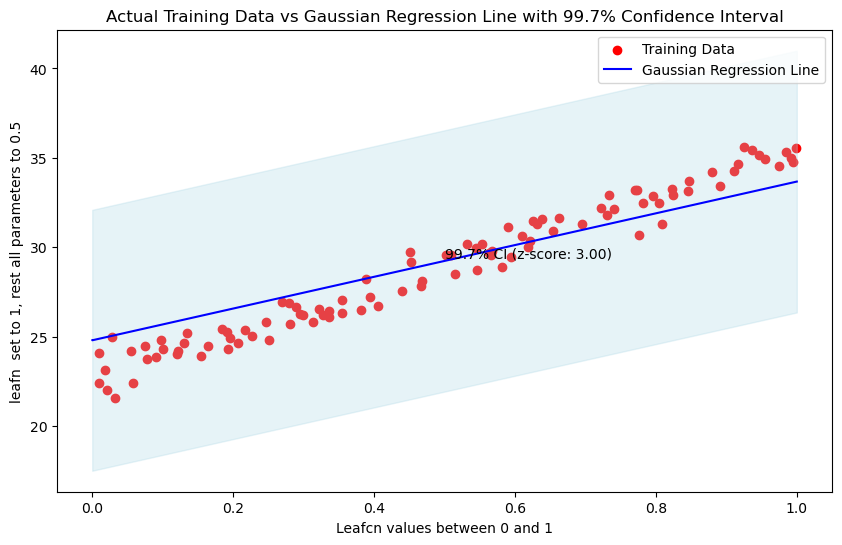

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import norm

# Define a custom function to generate the Gaussian regression line
def gaussian_regression_line(model, X):
    # Generate x_values with 32 dimensions
    x_values = np.full((10, 32), 0)  # Fill array with 0.5
    x_values[:, 15] = np.linspace(0, 1, 10)  # Set the 15th column values to evenly spaced values from 0 to 1

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_mean, y_std = model.predict(x_values, return_std=True)

    # Plot the mean line
    plt.plot(x_values[:, 15], y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
    plt.fill_between(x_values[:, 15], y_mean - z_score * y_std, y_mean + z_score * y_std, color='lightblue', alpha=0.3)


    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')

# Plot the actual training data against the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 15], cv_predictions, color='red', label='Training Data')
gaussian_regression_line(gp_model_cv, X_test)
plt.xlabel('Leafcn values between 0 and 1')
plt.ylabel('leafn  set to 1, rest all parameters to 0.5')
plt.title('Actual Training Data vs Gaussian Regression Line with 99.7% Confidence Interval')
plt.legend()
plt.show()


#### Sensitivity test for all individual parameters for leafn

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define a custom function to generate the Gaussian regression line for each parameter
#parameter names should be passed to bring in values from lookup table
def gaussian_regression_lines(model, X, parameter_names):
    plt.figure(figsize=(15, 10))  # Adjust figure size as needed
    for param_index in range(32):
        # Generate x_values with 32 dimensions
        x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
        x_values[:, param_index] = np.linspace(0, 1, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

        # Predict mean and standard deviation of the Gaussian process at each point in x_values
        y_mean, y_std = model.predict(x_values, return_std=True)

        # Plot the mean line for the current parameter
        plt.subplot(4, 8, param_index + 1)  # Adjust subplot layout according to the number of parameters
        plt.plot(x_values[:, param_index], y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')

        # Calculate the z-score for the 99.7% confidence interval
        z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

        # Plot the shaded region for the 99.7% confidence interval with three standard deviations
        plt.fill_between(x_values[:, param_index], y_mean - z_score * y_std, y_mean + z_score * y_std, color='lightblue', alpha=0.3)

        # Plot the z-score value on the plot
        plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom')
        
        # Set title for each subplot based on the parameter name from the dictionary
        plt.title(parameter_names[param_index])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


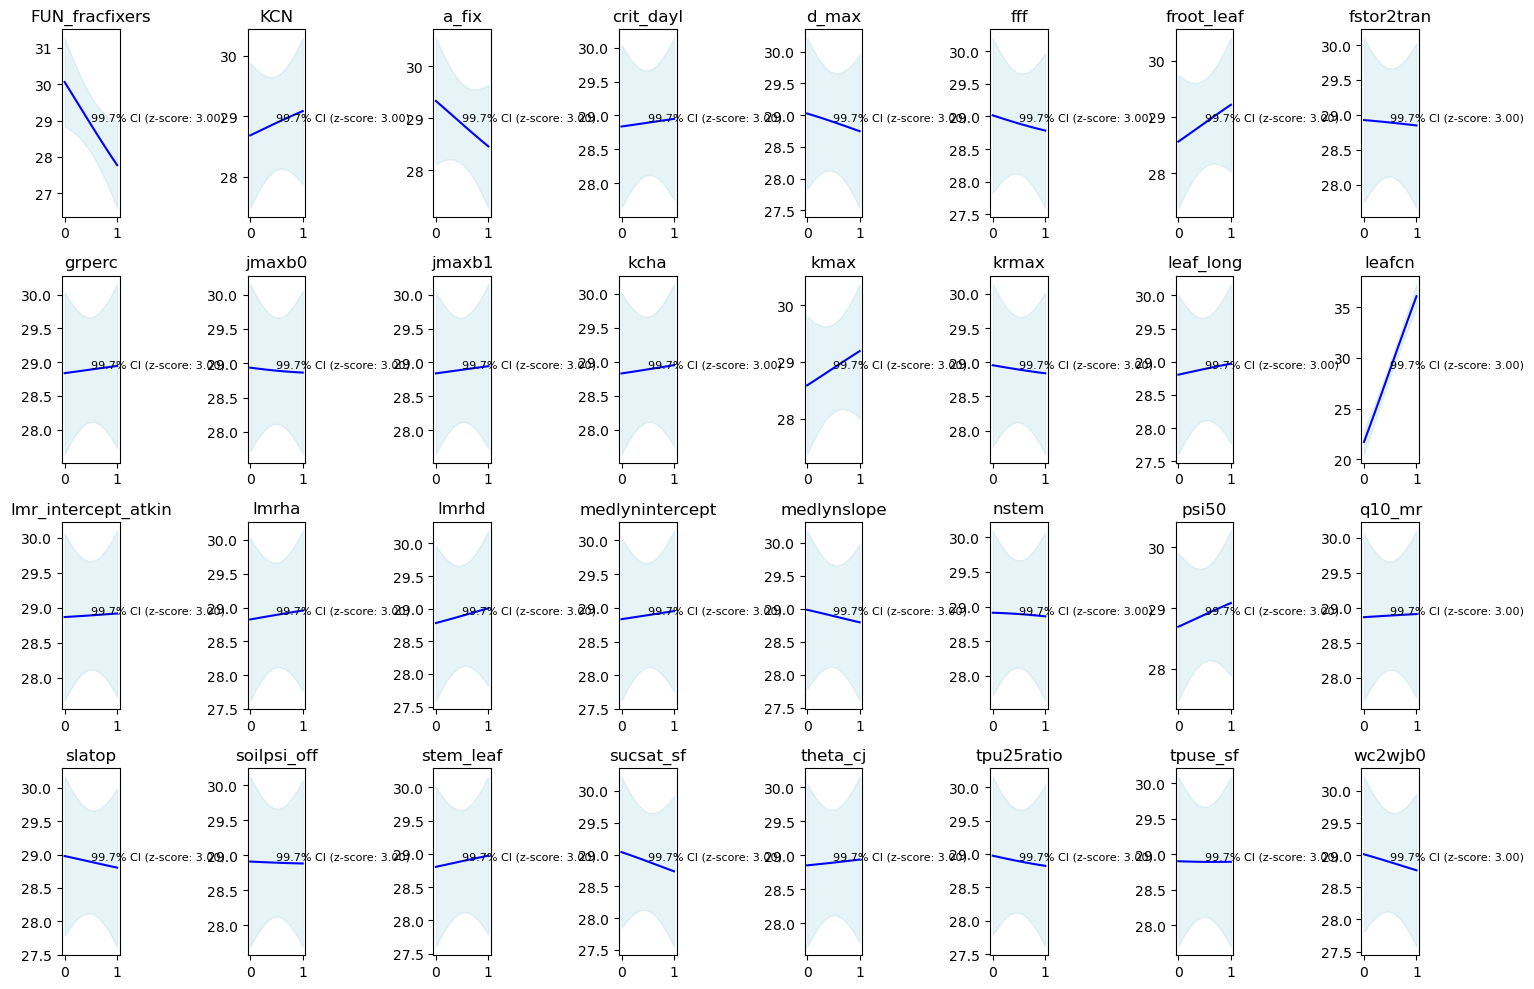

In [24]:
# Plot the Gaussian regression lines for each parameter
gaussian_regression_lines(gp_model_cv, X_test, list(names_of_parameters_dict.values()))

### FAST: Fourier Amplitude Sensitivity Test


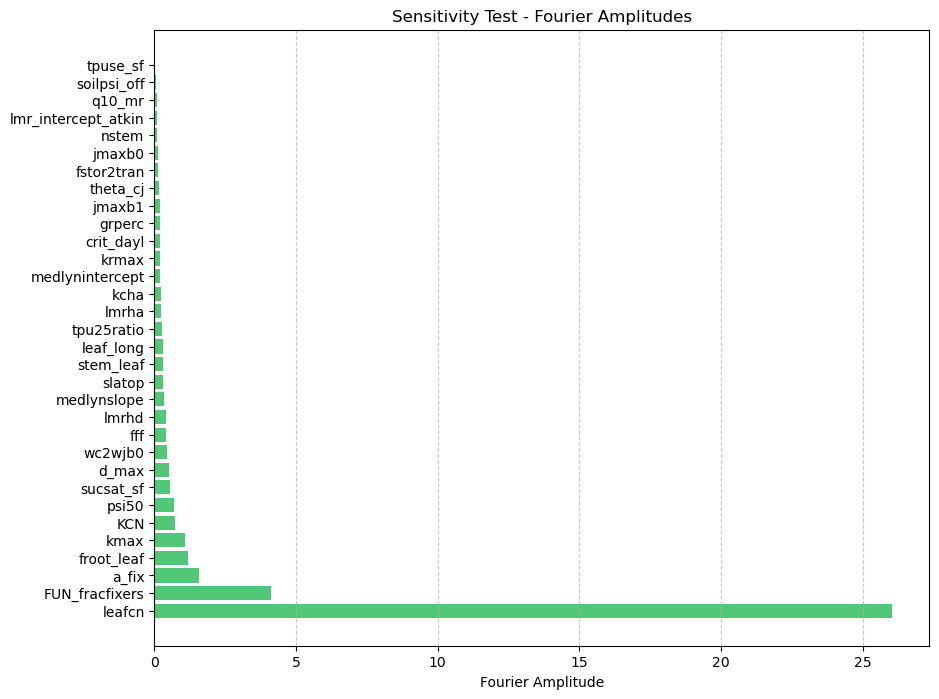

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.fft import fft

# Define a custom function to generate the Gaussian regression line for each parameter
def gaussian_regression_lines(model, X):
    fourier_amplitudes = []  # List to store Fourier amplitudes for each parameter
    
    for param_index in range(32):
        # Generate x_values with 32 dimensions
        x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
        x_values[:, param_index] = np.linspace(0, 1, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

        # Predict mean and standard deviation of the Gaussian process at each point in x_values
        y_mean, _ = model.predict(x_values, return_std=True)

        # Compute Fourier transform of the model output
        y_fft = fft(y_mean)

        # Compute amplitude of each frequency component
        amplitude = np.abs(y_fft)

        # Store the amplitude corresponding to the first non-zero frequency (excluding DC component)
        fourier_amplitudes.append(amplitude[1])

    return fourier_amplitudes

# Example usage:
# Assuming 'model' and 'X' are already defined
# Assuming 'names_of_parameters_dict' contains the parameter names dictionary

fourier_amplitudes = gaussian_regression_lines(gp_model_cv, X_test)

# Sort parameters based on Fourier amplitudes in descending order
sorted_indices = np.argsort(fourier_amplitudes)[::-1]
sorted_fourier_amplitudes = np.array(fourier_amplitudes)[sorted_indices]

# Extract parameter names corresponding to sorted indices from lookup table
sorted_parameter_names = [names_of_parameters_dict[index] for index in sorted_indices]

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_fourier_amplitudes)), sorted_fourier_amplitudes, color='#50c878')
plt.ylabel('')
plt.xlabel('Fourier Amplitude')
plt.title('Sensitivity Test - Fourier Amplitudes')
plt.yticks(range(len(sorted_fourier_amplitudes)), sorted_parameter_names)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Sobol Sensivity test

/glade/derecho/scratch/sbhattarai/tmp/ipykernel_8621/3665811767.py:17: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000, calc_second_order=False)
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


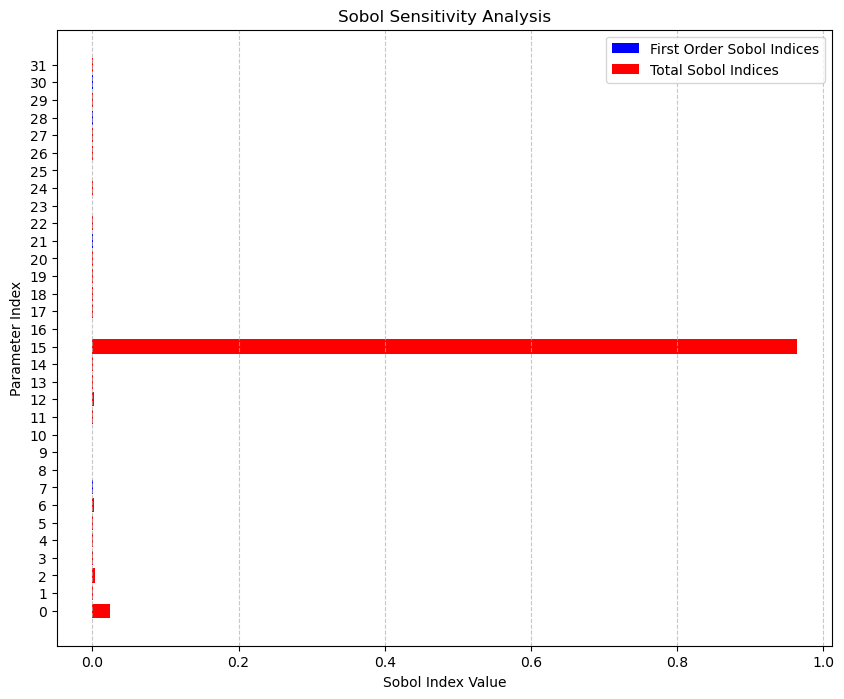

In [27]:
# from SALib.sample import saltelli
# from SALib.analyze import sobol

# # Define the problem dictionary
# problem = {
#     'num_vars': 32,  # Number of parameters
#     'names': [f'param_{i}' for i in range(32)],  # Parameter names
#     'bounds': [[0, 1]] * 32  # Parameter bounds (assuming they vary between 0 and 1)
# }

# # Define a custom function to perform Sobol sensitivity analysis
# def sobol_sensitivity_analysis(model, problem):
#     # Generate samples using Saltelli's extension to Sobol sequence
#     param_values = saltelli.sample(problem, 1000, calc_second_order=False)

#     # Run the model and obtain outputs
#     model_outputs, _ = model.predict(param_values, return_std=True)

#     # Perform Sobol sensitivity analysis
#     sobol_indices = sobol.analyze(problem, model_outputs, calc_second_order=False)

#     # Get the first-order and total Sobol indices
#     first_order_indices = sobol_indices['S1']
#     total_indices = sobol_indices['ST']

#     return first_order_indices, total_indices

# # Example usage:
# # Assuming 'gp_model_cv' and 'problem' are already defined
# first_order_indices, total_indices = sobol_sensitivity_analysis(gp_model_cv, problem)

# # Plotting
# plt.figure(figsize=(10, 8))
# plt.barh(range(len(first_order_indices)), first_order_indices, color='blue', label='First Order Sobol Indices')
# plt.barh(range(len(total_indices)), total_indices, color='red', label='Total Sobol Indices')
# plt.xlabel('Sobol Index Value')
# plt.ylabel('Parameter Index')
# plt.title('Sobol Sensitivity Analysis')
# plt.yticks(range(len(first_order_indices)), range(32))  # Assuming parameter indices are numbered from 0 to 31
# plt.legend()
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.show()